## Folosirea Keras-ului pentru a construi și a instrui rețele neuronale

În acest exercițiu, vom folosi o rețea neuronală pentru a prezice diabetul utilizând setul de date Pima Diabetes. Vom începe prin antrenarea unei păduri aleatorii pentru a obține o linie de bază a performanței. Apoi vom folosi pachetul Keras pentru a construi și a instrui rapid o rețea neuronală și a compara performanța. Vom vedea cum diferite structuri de rețea afectează performanța, timpul de antrenament și nivelul de suprasolicitare (sau subsolicitare).

## Setul de date UCI Pima pentru diabet



* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Atribute: (all numeric-valued)
   1. Numărul de sarcini
   2. Glicemia plasmatică la 2 ore într-un test de toleranță orală la glucoză
   3. Tensiunea arterială diastolică (mm Hg)
   4. Grosimea plicii cutanate tricepsului (mm)	
   5. Insulină serică la 2 ore (mu U/ml)
   6. Indicele de masă corporală (greutate în kg / (înălțime în m) ^ 2)
   7. Funcția de pedigree pentru diabet
   8. Vârsta (ani)
   9. Variabila clasei (0 sau 1)

Setul de date UCI Pima pentru diabet, care are 8 predictori numerici și un rezultat binar.

In [1]:
#Preliminarii

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [2]:
## Importă obiectele Keras pentru Învățare Profundă

from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K

In [22]:
## Incarcați setul de date (este necesar accesul la internet)

url = "diabetes.csv"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv(url, names=names, skiprows=1)

In [23]:
# Aruncați o privire la date - dacă există multe "NaN", s-ar putea să aveți probleme de conectivitate la internetprint(diabetes_df.shape)
diabetes_df.sample(5)

,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
87,2,100,68,25,71,38.5,0.324,26,0
596,0,67,76,0,0,45.3,0.194,46,0
103,1,81,72,18,40,26.6,0.283,24,0
14,5,166,72,19,175,25.8,0.587,51,1
487,0,173,78,32,265,46.5,1.159,58,0


In [24]:
# Check the first few rows of the DataFrame
print(diabetes_df.head())

# Check the data types of columns
print(diabetes_df.dtypes)

# Check for missing values
print(diabetes_df.isnull().sum())

   times_pregnant  glucose_tolerance_test  blood_pressure  skin_thickness  \
0               6                     148              72              35   
1               1                      85              66              29   
2               8                     183              64               0   
3               1                      89              66              23   
4               0                     137              40              35   

   insulin   bmi  pedigree_function  age  has_diabetes  
0        0  33.6              0.627   50             1  
1        0  26.6              0.351   31             0  
2        0  23.3              0.672   32             1  
3       94  28.1              0.167   21             0  
4      168  43.1              2.288   33             1  
times_pregnant              int64
glucose_tolerance_test      int64
blood_pressure              int64
skin_thickness              int64
insulin                     int64
bmi                      

In [25]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [26]:
# Împărțiți datele în setul de antrenare și setul de testare (75%, 25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=11111)

Mai sus, observăm că aproximativ 35% dintre pacienții din acest set de date au diabet, în timp ce 65% nu-l au. Acest lucru înseamnă că putem obține o acuratețe de 65% fără niciun model - pur și simplu declarăm că nimeni nu are diabet. Vom calcula scorul ROC-AUC pentru a evalua performanța modelului nostru și vom examina, de asemenea, acuratețea pentru a vedea dacă am îmbunătățit acuratețea de 65%.
## Exercițiu: Obțineți o performanță de bază folosind Random Forest
Pentru a începe și a obține o bază pentru performanța clasificatorului:

1. Antrenați un model Random Forest cu 200 de arbori pe datele de antrenare.
2. Calculați acuratețea și scorul roc_auc_score al predicțiilor.

In [27]:
## Antrenează Modelul RF
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [29]:
# Faceți predicții pe setul de testare - atât predicții "hard", cât și scorurile (procentul de arbori care votează "da")
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.760
roc-auc is 0.821


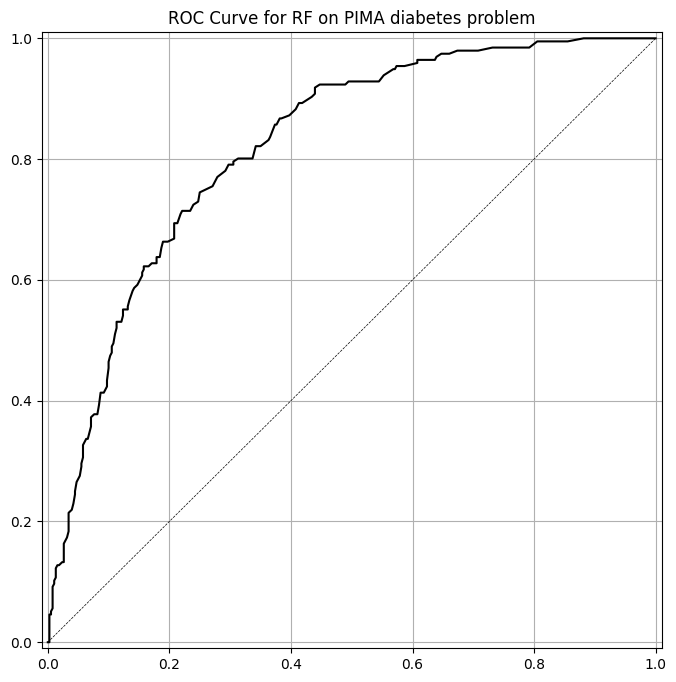

In [30]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Construiește o rețea neuronală cu un singur strat ascuns

Vom folosi modelul secvențial pentru a construi rapid o rețea neuronală. Prima noastră rețea va fi o rețea cu un singur strat ascuns. Avem 8 variabile, deci vom seta forma de intrare la 8. Să începem prin a avea un singur strat ascuns cu 12 noduri.

In [31]:
## Mai întâi să normalizăm datele
## Acest lucru ajută la antrenarea rețelelor neuronale prin asigurarea stabilității numerice
## Random Forest nu are nevoie de aceasta deoarece găsește doar o despărțire, spre deosebire de efectuarea de înmulțiri matriceale


normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [32]:
# Definiți Modelul
# Dimensiunea de intrare este 8-dimensională
# 1 strat ascuns, 12 noduri ascunse, activare sigmoid
# Stratul final are doar un nod cu activare sigmoid (standard pentru clasificare binară)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [33]:
# Acesta este un instrument util pentru a vizualiza modelul pe care l-ați creat și pentru a număra parametrii
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


Avem 121 de parametri deoarece avem:
- 8 ponderi (parametrii) pentru conexiunile dintre cele 8 noduri de intrare și cele 12 noduri din stratul ascuns (8 * 12 = 96 parametri)
- 12 ponderi (parametrii) pentru conexiunile dintre cele 12 noduri din stratul ascuns și nodul de ieșire (12 * 1 = 12 parametri)
- 12 valori de deplasare (bias) pentru cele 12 noduri din stratul ascuns
- 1 valoare de deplasare (bias) pentru nodul de ieșire

În total, avem 96 + 12 + 12 + 1 = 121 de parametri.

Da, acest lucru are sens, deoarece numărul de parametri corespunde arhitecturii rețelei noastre neuronale.

Vom antrena modelul nostru pentru 200 de epoci pentru a vedea cum se potrivește cu datele.

In [34]:
# Potrivire(Antrenare) Modelul
# Compilarea modelului cu Optimizatorul, Funcția de Pierdere și Metricile
# Roc-Auc nu este disponibil în Keras ca metrică gata făcută încă, deci o să-l omitem aici.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# Funcția fit returnează istoricul rulării.
# Este foarte convenabilă, deoarece conține informații despre potrivirea modelului, iterații etc.

Epoch 1/200
6/6 [==============================] - 1s 40ms/step - loss: 0.7938 - accuracy: 0.5625 - val_loss: 0.7977 - val_accuracy: 0.5955
Epoch 2/200
6/6 [==============================] - 0s 10ms/step - loss: 0.7905 - accuracy: 0.5625 - val_loss: 0.7946 - val_accuracy: 0.5972
Epoch 3/200
6/6 [==============================] - 0s 10ms/step - loss: 0.7872 - accuracy: 0.5677 - val_loss: 0.7915 - val_accuracy: 0.6024
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 0.7841 - accuracy: 0.5677 - val_loss: 0.7885 - val_accuracy: 0.6059
Epoch 5/200
6/6 [==============================] - 0s 12ms/step - loss: 0.7810 - accuracy: 0.5677 - val_loss: 0.7855 - val_accuracy: 0.6059
Epoch 6/200
6/6 [==============================] - 0s 10ms/step - loss: 0.7779 - accuracy: 0.5677 - val_loss: 0.7826 - val_accuracy: 0.6059
Epoch 7/200
6/6 [==============================] - 0s 9ms/step - loss: 0.7748 - accuracy: 0.5729 - val_loss: 0.7797 - val_accuracy: 0.6094
Epoch 8/200
6/6 [=====

In [40]:
## La fel cum am făcut pentru Random Forest, generăm două tipuri de predicții
# Unul este o decizie strictă, iar celălalt este un scor probabilistic.

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
y_pred_class_nn_1 = (y_pred_prob_nn_1 > 0.5).astype(int)

18/18 [==============================] - 0s 1ms/step


In [41]:
# Să examinăm ieșirile pentru a înțelege cum funcționează API-urile Keras.
y_pred_class_nn_1[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0]])

In [42]:
y_pred_prob_nn_1[:10]

array([[0.35744578],
       [0.6527199 ],
       [0.45394775],
       [0.41854507],
       [0.2563888 ],
       [0.3956425 ],
       [0.09873229],
       [0.5054431 ],
       [0.7167887 ],
       [0.43393356]], dtype=float32)

18/18 [==============================] - 0s 1ms/step
Acuratețe: 0.6875
Acuratețe de Validare: 0.6996527910232544
AUROC: 0.749906015037594


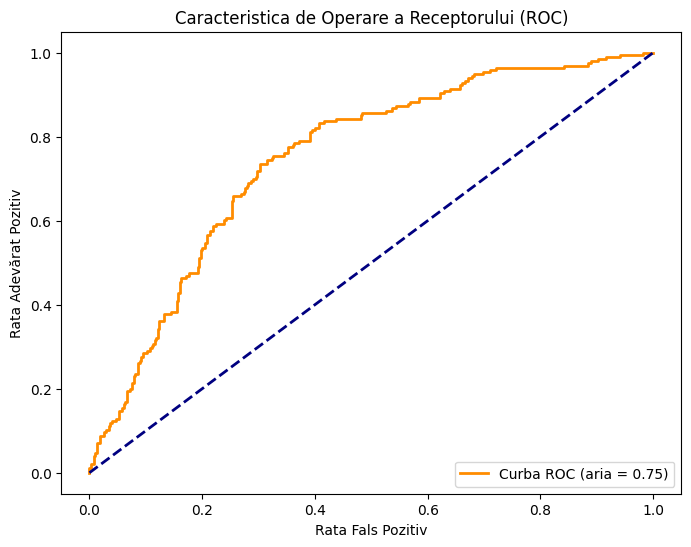

In [43]:
# Pentru a afișa performanța modelului și a trasa curba ROC, putem folosi următoarele instrucțiuni:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obținem predicțiile probabilităților pentru setul de testare
y_pred_proba = model_1.predict(X_test_norm)

# Calculam fpr, tpr și auroc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Afișam performanța modelului
print("Acuratețe:", run_hist_1.history['accuracy'][-1])
print("Acuratețe de Validare:", run_hist_1.history['val_accuracy'][-1])
print("AUROC:", roc_auc)

# Trasam curba ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curba ROC (aria = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Rata Fals Pozitiv')
plt.ylabel('Rata Adevărat Pozitiv')
plt.title('Caracteristica de Operare a Receptorului (ROC)')
plt.legend(loc="lower right")
plt.show()


Pot exista unele variații în numerele exacte datorită aleatorietății, dar ar trebui să obțineți rezultate în același interval ca Random Forest - între 75% și 85% acuratețe, între 0.8 și 0.9 pentru AUC.

Să ne uităm la obiectul `run_hist_1` care a fost creat, în special la atributul său `history`.

In [44]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Vom trasa pierderea antrenamentului și pierderea validării pe diferite epoci și vom vedea cum arată.

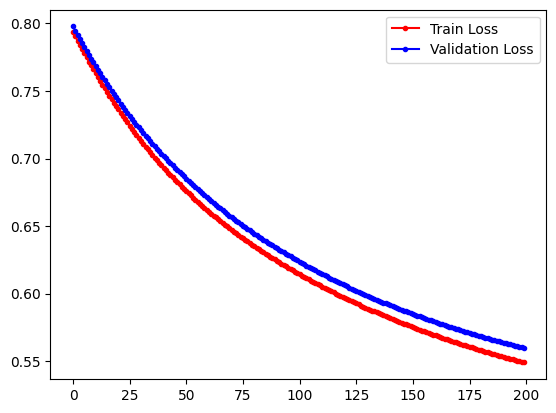

In [45]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Pare că pierderile continuă să scadă atât pe setul de antrenament, cât și pe setul de validare. Acest lucru sugerează că modelul ar putea beneficia de mai mult antrenament. Să antrenăm modelul puțin mai mult și să vedem ce se întâmplă. Rețineți că va continua de unde a rămas. Antrenați-l pentru încă 1000 de epoci.

In [46]:
## Rețineți că atunci când apelăm din nou "fit", va continua de unde a rămas
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Epoch 1/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.5487 - accuracy: 0.6875 - val_loss: 0.5594 - val_accuracy: 0.6997
Epoch 2/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.5482 - accuracy: 0.6875 - val_loss: 0.5589 - val_accuracy: 0.6997
Epoch 3/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.5477 - accuracy: 0.6927 - val_loss: 0.5585 - val_accuracy: 0.6997
Epoch 4/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.5473 - accuracy: 0.6927 - val_loss: 0.5581 - val_accuracy: 0.6997
Epoch 5/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.5469 - accuracy: 0.6927 - val_loss: 0.5577 - val_accuracy: 0.6997
Epoch 6/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5465 - accuracy: 0.6979 - val_loss: 0.5573 - val_accuracy: 0.6997
Epoch 7/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.5460 - accuracy: 0.6979 - val_loss: 0.5569 - val_accuracy: 0.6997
Epoch 8/1000
6

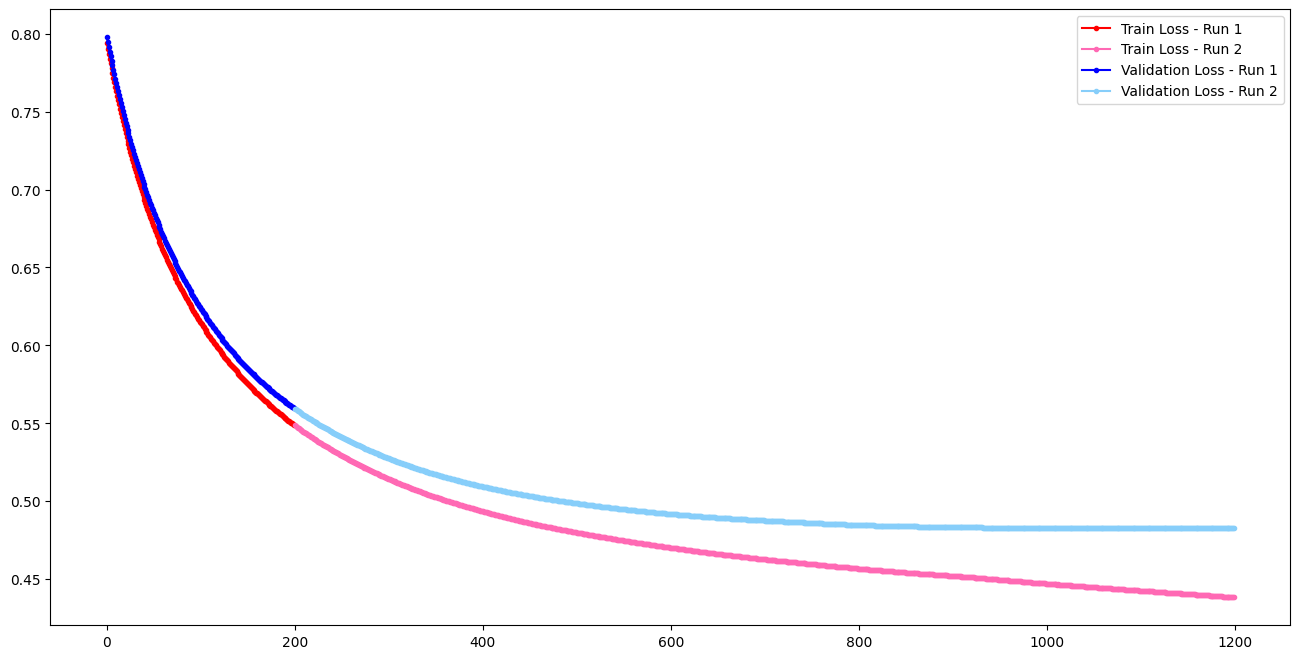

In [47]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Rețineți că acest grafic începe acolo unde a rămas celălalt. În timp ce pierderea antrenamentului continuă să scadă, pare că pierderea de validare s-a stabilizat (sau chiar a devenit mai rea!). Acest lucru sugerează că rețeaua noastră nu va beneficia de mai mult antrenament. Care este numărul adecvat de epoci?

In [ ]:
Numărul adecvat de epoci este acolo unde pierderea de validare începe să se stabilizeze sau să crească, în timp ce pierderea de antrenament continuă să scadă.
Acest lucru sugerează că modelul nu mai învață în mod semnificativ după acest punct și că ar trebui să oprim antrenamentul la această etapă pentru a evita supraantrenarea.
În cazul acestui model specific, ar putea fi între 200 și 300 de epoci, deoarece la acest punct pierderea de validare pare să se stabilizeze.
Totuși, numărul optim de epoci poate varia în funcție de complexitatea problemei, dimensiunea setului de date și arhitectura rețelei.
Este întotdeauna o idee bună să urmăriți graficul pierderii și să opriți antrenamentul când pierderea de validare începe să se stabilizeze sau să crească.

## Exercițiu
Acum este rândul tău. Fă următoarele în celulele de mai jos:
- Construiește un model cu două straturi ascunse, fiecare având 6 noduri
- Folosește funcția de activare "relu" pentru straturile ascunse și "sigmoid" pentru stratul final
- Folosește o rată de învățare de 0.003 și antrenează timp de 1500 de epoci
- Graficează traiectoria funcțiilor de pierdere, precizia atât pe setul de antrenare, cât și pe cel de testare
- Plotează curba roc pentru predicții

Experimentează cu diferite rate de învățare, număr de epoci și structuri de rețea.

In [50]:

# # Scrieți codul aici pentru a avea activarea relu în straturile 1 și 2 și activarea sigmoid în straturile 3

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


In [56]:
model = Sequential()
model.add(Dense(6, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
learning_rate = 0.003
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=1500, batch_size=32, validation_data=(X_test, y_test), verbose=0)


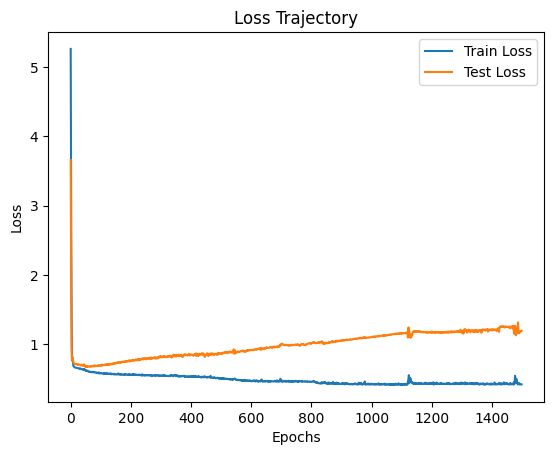

In [57]:
# Scrieți codul aici pentru a trasa pierderea, acuratețea și curba ROC.

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trajectory')
plt.legend()
plt.show()

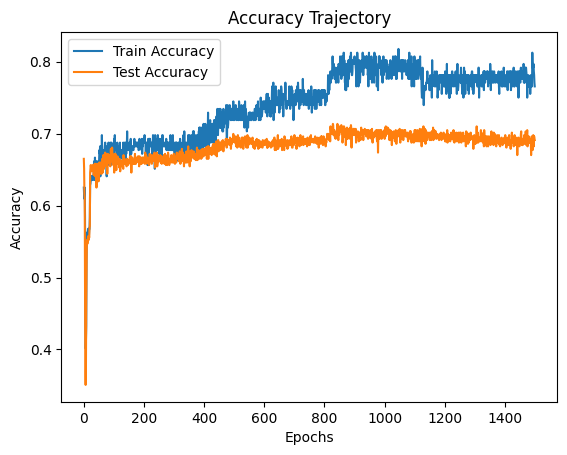

In [58]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Trajectory')
plt.legend()
plt.show()

18/18 [==============================] - 0s 1ms/step


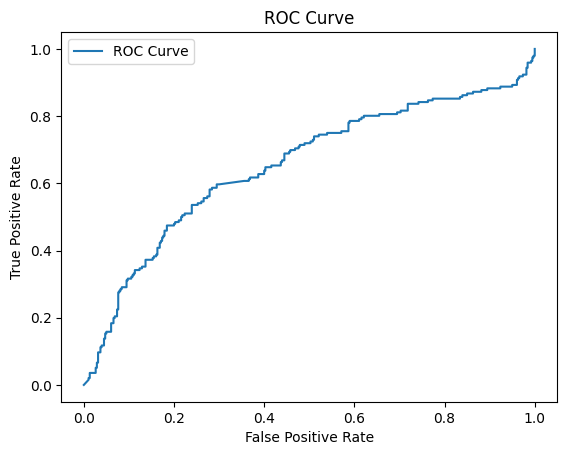

In [59]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()